In [2]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2

from argparse import ArgumentParser
from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator
import scipy.misc


Using TensorFlow backend.


In [10]:
TRAIN_DIR = './data_train/'
TEST_DIR = '/content/drive/My Drive/Python/huawei/Unet/DATA'


BATCH_SIZE = 4
STATE =  'train'
LOGS = './logs'
MODEL_NAME = 'default'

boxes_path = './data_train/boxes.txt'
checkpoint = './weights/pconv_imagenet.h5'
vgg_weights='./weights/pytorch_vgg16.h5'

In [4]:
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample            
            mask = np.stack([
                mask_generator.sample(seed)
                for _ in range(ori.shape[0])], axis=0
            )

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            

# Create training generator
train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    MaskGenerator(512, 512, 3, maskspath=boxes_path, rand_seed=154),
    target_size=(512, 512), 
    batch_size=BATCH_SIZE
)


# Create testing generator
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(512, 512, 3, maskspath=boxes_path, rand_seed=154), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

Found 577 images belonging to 1 classes.


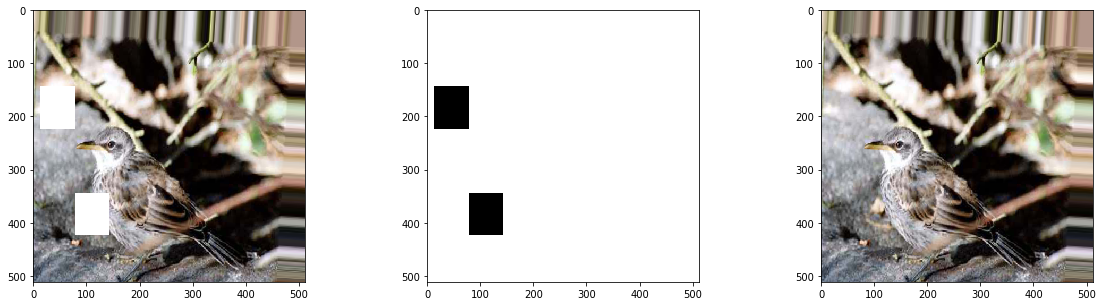

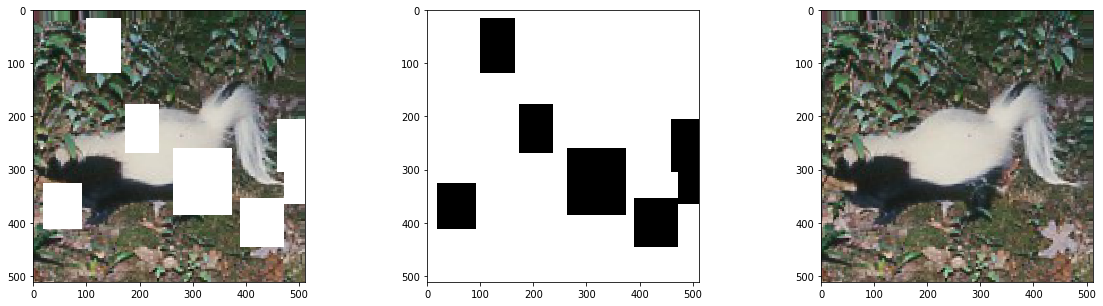

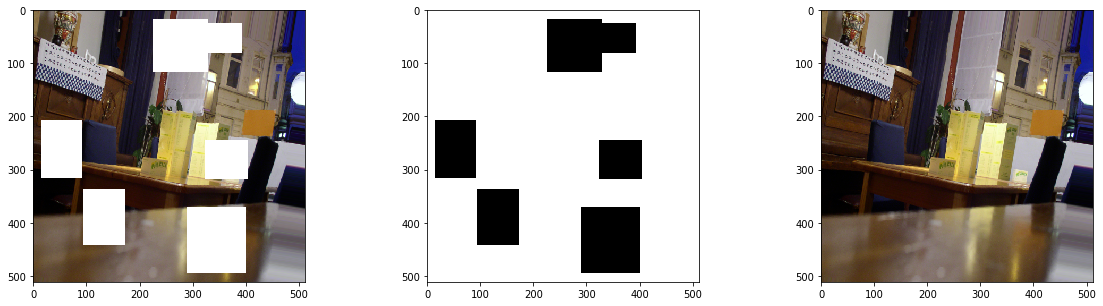

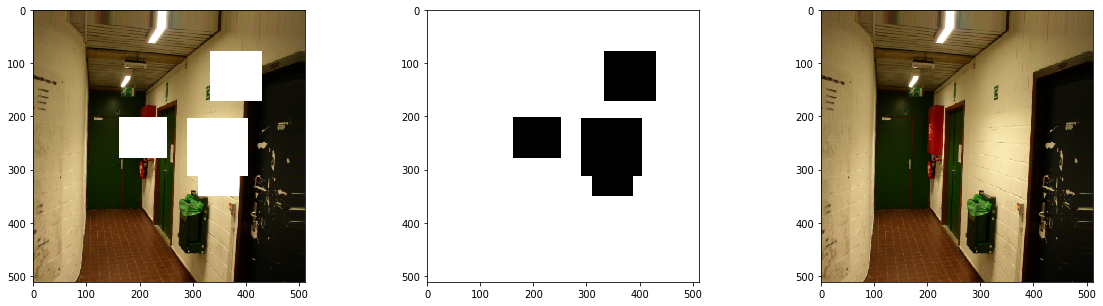

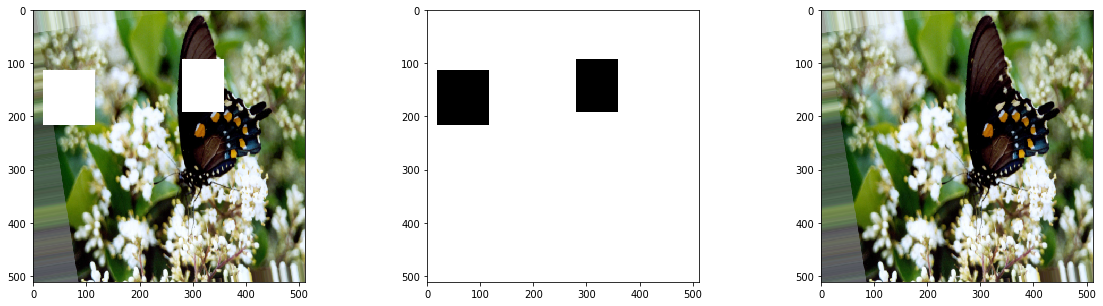

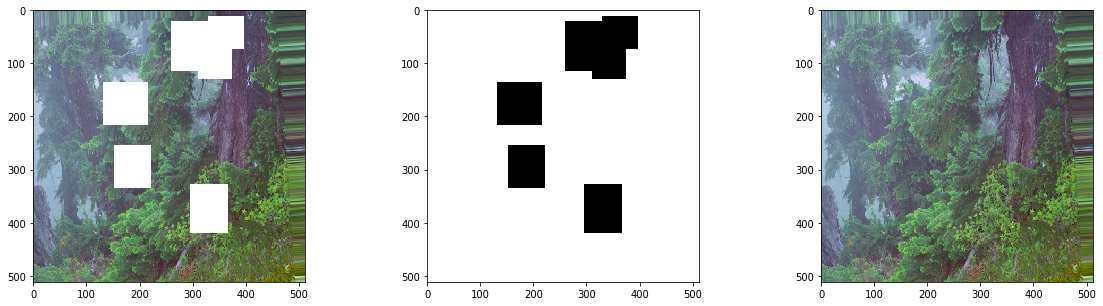

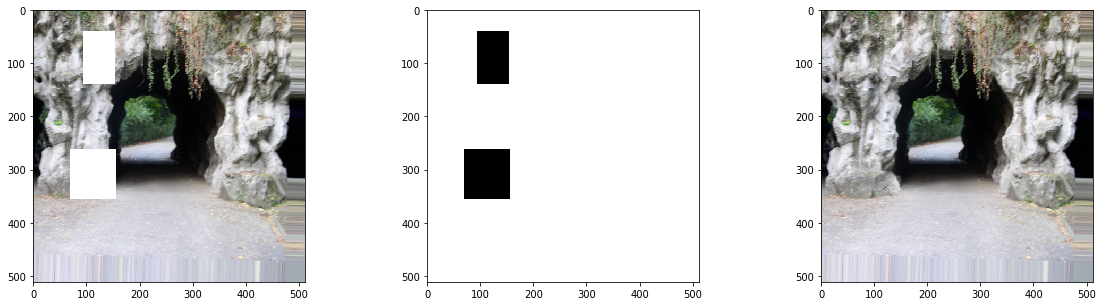

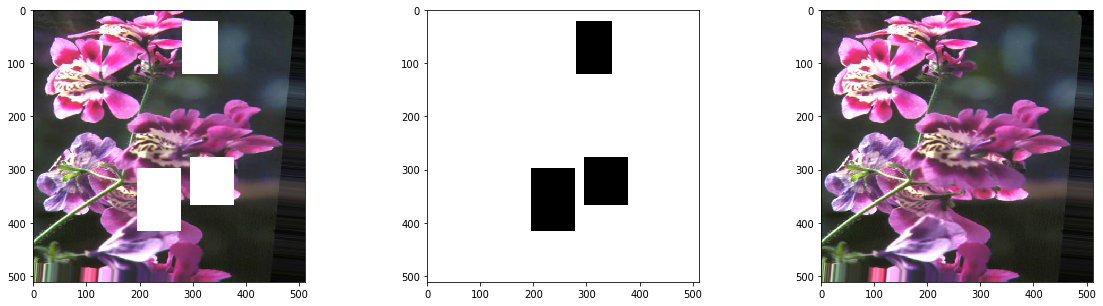

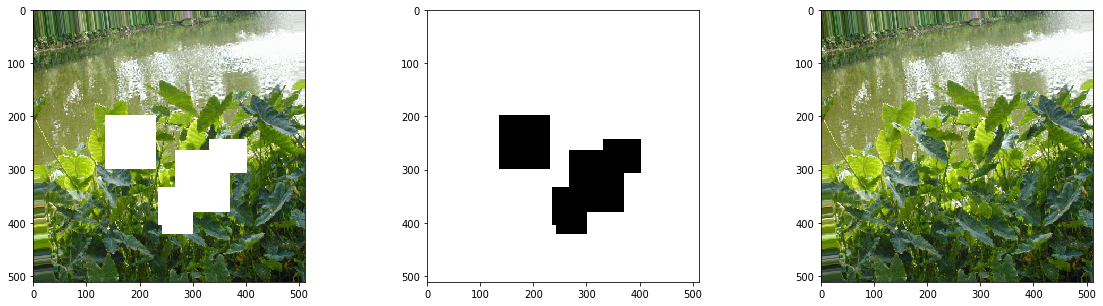

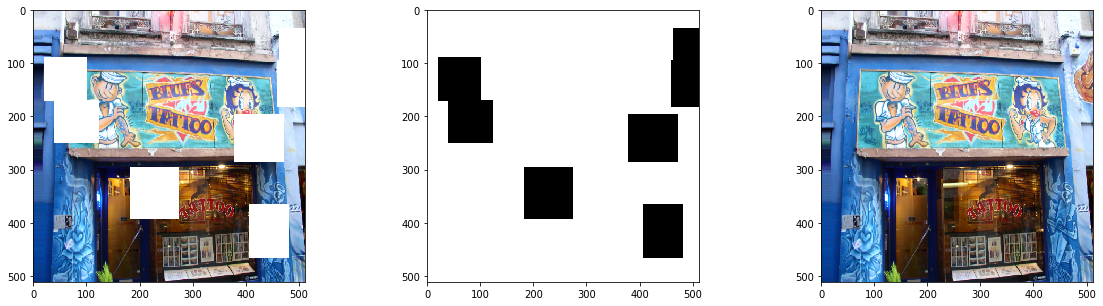

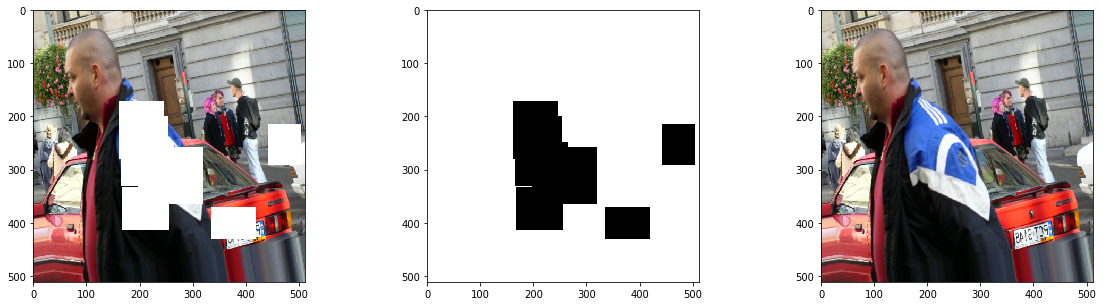

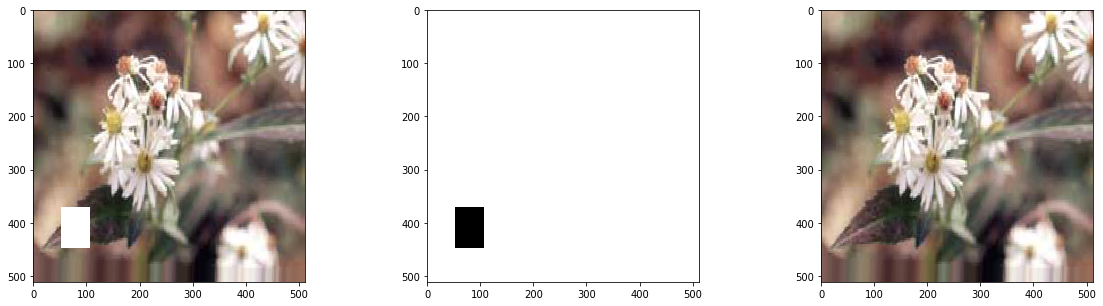

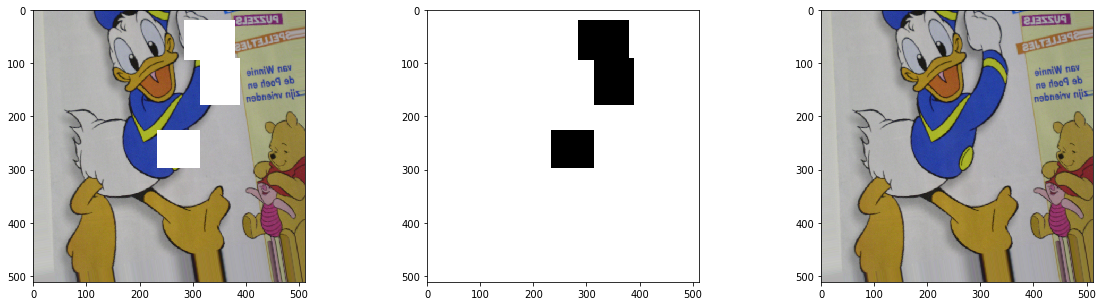

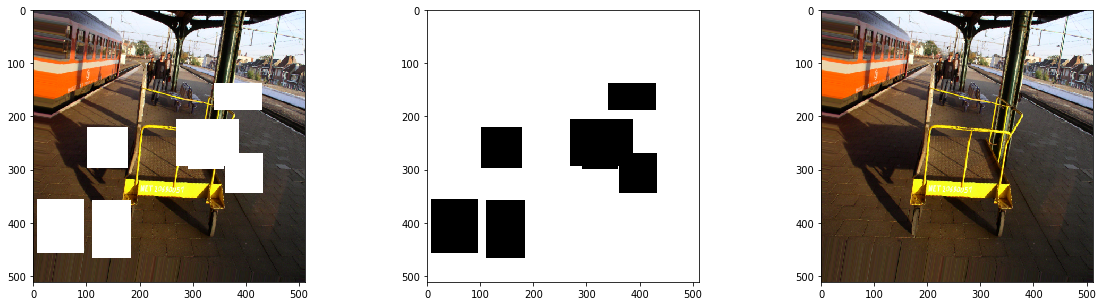

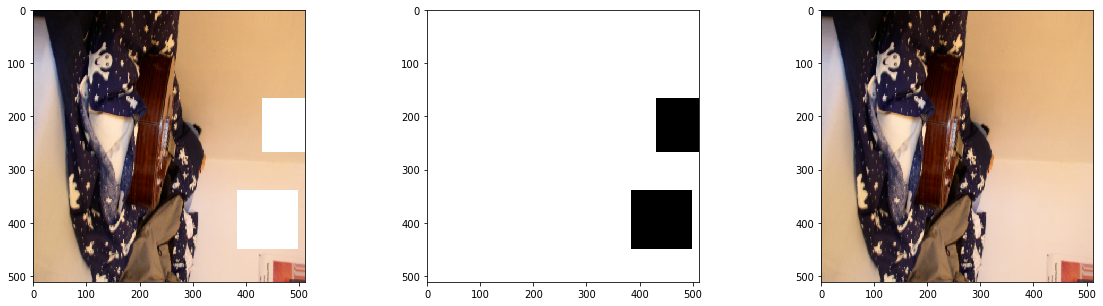

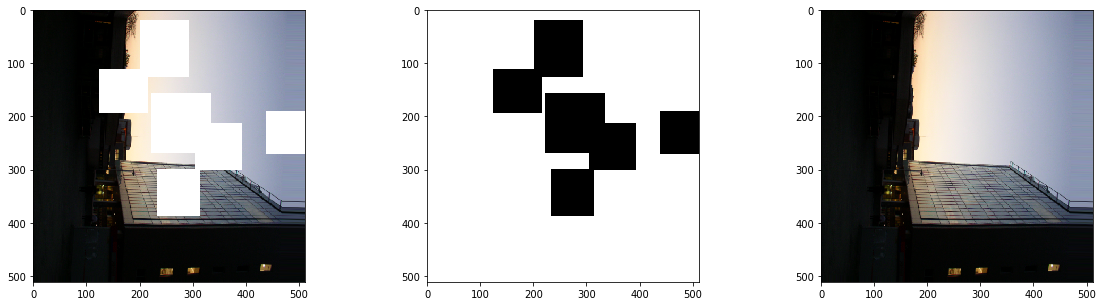

In [5]:
# Pick out an example
test_data = next(train_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

In [7]:
def plot_callback(model, path):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""

    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        image = np.hstack([masked[i,:,:,:],pred_img[i,:,:,:],ori[i,:,:,:]])
        scipy.misc.imsave(logs+'{}_pictures/outfile.jpg'.format(pred_time), image)
        plt.imshow(image)
    print('Saving images to {}'.format(path))

In [12]:
checkpoint

'./weights/pconv_imagenet.h5'

In [14]:
# # Load the model
# if len(vgg_weights) > 0:
#     model = PConvUnet(vgg_weights=vgg_weights)
# else:
#     model = PConvUnet()

# Loading of checkpoint
if len(checkpoint)>0:
    if STATE == 'train':
        model.load(checkpoint)
    elif STATE == 'finetune':
        model.load(checkpoint, train_bn=False, lr=0.00005)

ValueError: invalid literal for int() with base 10: 'h5'

# TRAIN

In [ ]:
NUM_EPOCHS = 20
VAL_STEPS = 50
STEPS_PER_EPOCH = 100

# Fit model
model.fit_generator(
    train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=val_generator,
    validation_steps=VAL_STEPS,
    epochs=NUM_EPOCHS,  
    verbose=0,
    callbacks=[
         TensorBoard(
             log_dir=os.path.join(LOGS, MODEL_NAME+'_phase1'),
             write_graph=False
         ),
         ModelCheckpoint(
             os.path.join(LOGS, MODEL_NAME, 'weights.{epoch:02d}-{loss:.2f}.h5'),
             monitor='val_loss', 
             save_best_only=True, 
             save_weights_only=True
         ),
         LambdaCallback(
             on_epoch_end=lambda epoch, logs: plot_callback(model, LOGS)),
        TQDMCallback()
     ]
)

# PREDICT TES


In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        #plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        #plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 10:
        break